# Song lyrics - Part 1: Overview

This is the first of several notebooks examining the song lyrics dataset. This notebook explores some basic properties of the dataset, while also tidying up the data for analysis in the following notebooks.

### Imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)

### Data

The dataset used here is the table of artist/album/song info and lyrics for every song in the core dataset.

In [3]:
df = pd.read_csv('songs.csv', low_memory=False)
df = df[~df.song_darklyrics.isnull()]
df = df[df.song_darklyrics.str.strip().apply(len) > 0]
print(df.columns)

Index(['band_name', 'band_id', 'band_url', 'band_country_of_origin',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes', 'band_last_label', 'band_years_active',
       'album_name', 'album_type', 'album_year', 'album_review_num',
       'album_review_avg', 'album_url', 'album_reviews_url', 'song_name',
       'song_length', 'song_url', 'song_darklyrics', 'song_darklyrics_url',
       'band_current_label'],
      dtype='object')


### Reduced dataset

For lyrical analyses the data is reduced to just a column of lyrics (which will become the feature vector upon some transformation to a quantitative representation) for each song and columns for the most popular genres (the target/label vectors). These are the genres that appear at least once in isolation, i.e. not accompanied by any other genre, and that appear in some minimum percentage of songs. For example, the "black" metal label can appear on bands with or without other genres, but a label like "atmospheric" never appears on its own despite being fairly popular, usually because it is more of an adjective to denote subgenres like atmospheric black metal; thus "black" is included in the reduced label space but "atmospheric" is not. This reduces the genres to a more manageable set: five genres if the minimum occurrence requirement is set to 10%, and thirteen if set to 1%.

A five-genre set would be easier to handle but leaves quite a few holes in the label space, because doom metal, metalcore, folk metal, and many other fairly popular genres are being omitted that may not be covered by any of the five labels. The larger label set covers just about all the most important genres, but because eight of them occur in fewer than 10% of all songs, they will force greater class imbalance which will adversely affect attempts at applying binary classification models later on. For the sake of comparison, both reduced datasets are saved here, but the rest of this exploratory analysis only looks at the 1% dataset, while the 10% dataset is reserved for modeling. Each dataset is saved in its raw form and in a truncated (ML-ready) form containing only the lyrics and genre columns.

In [4]:
def process_genre(genre):
    # Find words (including hyphenated words) not in parentheses
    out = re.findall('[\w\-]+(?![^(]*\))', genre.lower())
    out = [s for s in out if s != 'metal']
    return out


song_genres = df.band_genre.apply(process_genre)
genres = sorted(set(song_genres.sum()))
genre_cols = [f'genre_{genre}' for genre in genres]
for genre, col in zip(genres, genre_cols):
    df[col] = song_genres.apply(lambda x: int(genre in x))

In [5]:
def get_top_genres(data, min_pct):
    isolated = (data.sum(axis=1) == 1)
    isolated_cols = sorted(set(data[isolated].idxmax(axis=1)))
    top_cols = [col for col in isolated_cols if data[col][isolated].mean() >= min_pct]
    top_genres = [re.sub(r"^genre\_", "", col) for col in top_cols]
    return top_genres

In [290]:
top_genres_10pct = get_top_genres(df[genre_cols], 0.1)
print(top_genres_10pct)
df_rr = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres_10pct)]
df_rr.drop(drop_cols, axis=1, inplace=True)
df_rr.to_csv('songs-10pct.csv', index=False)

# Only lyrics and genre are relevant for ML later
df_rr_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres)
df_rr_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_rr_ml[top_genres_10pct] = df[[f"genre_{genre}" for genre in top_genres_10pct]].reset_index(drop=True)
df_rr_ml.to_csv('songs-ml-10pct.csv', index=False)

['black', 'death', 'heavy', 'power', 'thrash']


In [292]:
top_genres_1pct = get_top_genres(df[genre_cols], 0.01)
print(top_genres_1pct)
df_r = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres_1pct)]
df_r.drop(drop_cols, axis=1, inplace=True)
df_r.to_csv('songs-1pct.csv', index=False)

# Only lyrics and genre are relevant for ML later
df_r_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres_1pct)
df_r_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_r_ml[top_genres_1pct] = df[[f"genre_{genre}" for genre in top_genres_1pct]].reset_index(drop=True)
df_r_ml.to_csv('songs-ml-1pct.csv', index=False)

['black', 'death', 'deathcore', 'doom', 'folk', 'gothic', 'grindcore', 'heavy', 'metalcore', 'power', 'progressive', 'symphonic', 'thrash']


# Basic lyrical properties

Below are the distributions of word counts per song, album, band, and genre. [Part 3](./lyrics2.ipynb) dives much deeper into evaluating lyrical complexity using various lexical diversity measures from the literature.

# Word counts by song

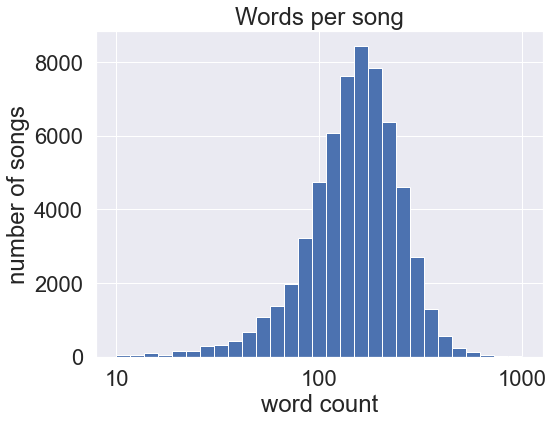

In [167]:
song_word_counts = df_r.song_darklyrics.str.split().apply(len)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
song_word_counts.hist(bins=np.logspace(1, 3, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of songs")
ax.set_title("Words per song")
plt.show()

In [168]:
def to_seconds(data):
    out = pd.Series(index=data.index, dtype=int)
    for i, x in data.song_length.items():
        if isinstance(x, str):
            xs = x.split(':')
            if len(xs) < 3:
                xs = [0] + xs
            seconds = int(xs[0]) * 3600 + int(xs[1]) * 60 + int(xs[2])
        else:
            seconds = 0
        out[i] = seconds
    return out

song_seconds = to_seconds(df_r)
song_words_per_second = song_word_counts / song_seconds
song_words_per_second[song_words_per_second == np.inf] = 0

df_r_songs = df_r[['band_name', 'album_name', 'song_name', 'band_genre']].copy()
df_r_songs['song_word_count'] = song_word_counts
df_r_songs['song_seconds'] = song_seconds
df_r_songs['song_words_per_second'] = song_words_per_second

### Songs with highest word counts

In [169]:
df_r_songs.sort_values('song_word_count')[:-10:-1]

,band_name,album_name,song_name,band_genre,song_word_count,song_seconds,song_words_per_second
11862,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,2392,358,6.681564
35657,Edge of Sanity,Crimson,Crimson,Progressive Death Metal,2018,2400,0.840833
100430,Theocracy,Mirror of Souls,Mirror of Souls,Epic Progressive Power Metal,1602,1346,1.190193
11822,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,To Dethrone the Witch-Queen of Mytos K'unn (Th...,Symphonic/Epic Black Metal,1413,405,3.488889
11866,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,1344,262,5.129771
11838,Bal-Sagoth,Battle Magic,Blood Slakes the Sand at the Circus Maximus,Symphonic/Epic Black Metal,1280,533,2.401501
81809,Redemption,Redemption,Something Wicked This Way Comes,Progressive Metal,1182,1466,0.806276
82509,Rhapsody of Fire,From Chaos to Eternity,Heroes of the Waterfalls' Kingdom,Symphonic Power Metal,1167,1172,0.995734
15057,Blind Guardian,A Night at the Opera,And Then There Was Silence,"Speed Metal (early), Power Metal (later)",1088,846,1.286052


The honor of highest word count in a single song goes to the [Bal-Sagoth's "The Obsidian Crown Unbound"](https://youtu.be/xizMG4nI2dk) at over two thousand words. However, most of those words are not sung in the actual song: Bal-Sagoth lyrics typically include the massive collection of narrative text that accompanies their songs. Although the lyrics they sing are still plentiful, there are nowhere near two thousand words spoken in the six-minute symphonic black metal track.

This makes the forty-minute prog metal epic [Crimson by Edge of Sanity](https://youtu.be/St6lJaiHYIc) a better contender for most verbose song. Still, such a claim might be challenged by the fact that the digital edition of the album, which a listener would find on Spotify for instance, divides the single-track album into eight parts. That said, DarkLyrics keeps the original one-track format.

At third place is another multi-part song, [Mirror of Souls](https://youtu.be/y6n1kMsLbc8) by the Christian progressive/power metal group Theocracy. This is less contentious since the official track listing considers this a single track.

### Songs with highest word density

Again "The Obsidian Crown Unbound" tops the charts for highest number of words per second, however at second place, is ["The Ghosts of Christmas Eve"](https://youtu.be/bT4ruFp5U2w), the two-minute intro track to The Christmas Attic by Trans-Siberian Orchestra. Most of the other tracks on this table are short, typically less than a minute.

In [170]:
df_r_songs.sort_values('song_words_per_second')[:-10:-1]

,band_name,album_name,song_name,band_genre,song_word_count,song_seconds,song_words_per_second
11862,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,2392,358,6.681564
103209,Trans-Siberian Orchestra,The Christmas Attic,The Ghosts of Christmas Eve,Orchestral/Progressive Rock/Metal,838,135,6.207407
61709,Macabre,Gloom,I Need to Kill,Thrash/Death Metal/Grindcore,209,36,5.805556
11866,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,1344,262,5.129771
84364,S.O.D.,Bigger than the Devil,Charlie Don't Cheat,Hardcore/Crossover/Thrash Metal,113,25,4.520000
80005,Putrid Pile,Paraphiliac Perversions,Toxic Shock Therapy,Brutal Death Metal,18,4,4.500000
17421,Brujeria,Raza odiada,Sesos humanos (Sacrificio IV),Death Metal/Grindcore,308,75,4.106667
70012,Napalm Death,Scum,You Suffer,"Hardcore Punk (early), Grindcore/Death Metal (...",4,1,4.000000
23586,Circle of Dead Children,Human Harvest,White Trash Headache,"Brutal Death Metal, Grindcore",24,6,4.000000


# Word counts by album

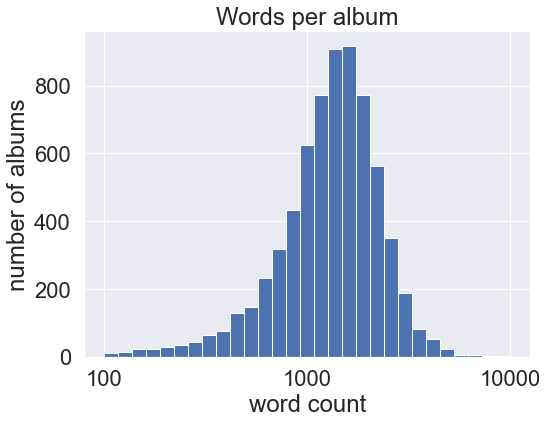

In [104]:
album_lyrics = df_r.groupby('album_name').song_darklyrics.sum()
album_word_counts = album_lyrics.str.split().apply(len)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
album_word_counts.hist(bins=np.logspace(2, 4, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of albums")
ax.set_title("Words per album")
plt.show()

In [243]:
df_r_albums = pd.concat((
    df_r_songs.groupby(['band_name', 'album_name']).first()[['band_genre']],
    df_r_songs.groupby(['band_name', 'album_name'])[['song_word_count', 'song_seconds']].sum()
), axis=1).reset_index()
df_r_albums.columns = ['band_name', 'album_name', 'band_genre', 'album_word_count', 'album_seconds']
df_r_albums['album_words_per_second'] = df_r_albums.album_word_count / df_r_albums.album_seconds
df_r_albums.loc[df_r_albums['album_words_per_second'] == np.inf, 'album_words_per_second'] = 0

### Albums with highest word counts

In [244]:
df_r_albums.sort_values('album_word_count')[:-10:-1]

,band_name,album_name,band_genre,album_word_count,album_seconds,album_words_per_second
924,Blind Guardian,Twilight Orchestra: Legacy of the Dark Lands,"Speed Metal (early), Power Metal (later)",9203,8210,1.120950
676,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,7487,3639,2.057433
675,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,6948,3157,2.200824
1514,Dalriada,Arany-album,Folk Metal,6151,4503,1.365978
5413,Savatage,The Wake of Magellan,"Heavy/Power Metal, Progressive Metal/Rock",5478,3218,1.702300
653,Ayreon,The Human Equation,Progressive Metal/Rock,5178,5950,0.870252
6293,Therion,Beloved Antichrist,"Death Metal (early), Symphonic/Operatic Metal ...",5073,9110,0.556861
3820,Machine Head,Catharsis,"Groove/Thrash Metal, Nu-Metal",5014,4457,1.124972
6437,Trans-Siberian Orchestra,The Christmas Attic,Orchestral/Progressive Rock/Metal,4946,4066,1.216429


### Albums with highest word density

In [246]:
df_r_albums.sort_values('album_words_per_second')[:-10:-1]

,band_name,album_name,band_genre,album_word_count,album_seconds,album_words_per_second
675,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,6948,3157,2.200824
4275,Municipal Waste,Waste 'Em All,Thrash Metal/Crossover,1757,848,2.071934
676,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,7487,3639,2.057433
4704,Origin,Informis Infinitas Inhumanitas,Technical Brutal Death Metal,3132,1712,1.829439
449,Archspire,Relentless Mutation,Technical Death Metal,3201,1837,1.742515
1017,Brujeria,Raza odiada,Death Metal/Grindcore,4213,2418,1.742349
5413,Savatage,The Wake of Magellan,"Heavy/Power Metal, Progressive Metal/Rock",5478,3218,1.702300
4271,Municipal Waste,Hazardous Mutation,Thrash Metal/Crossover,2393,1425,1.679298
4274,Municipal Waste,The Art of Partying,Thrash Metal/Crossover,3080,1881,1.637427


# Word counts by band

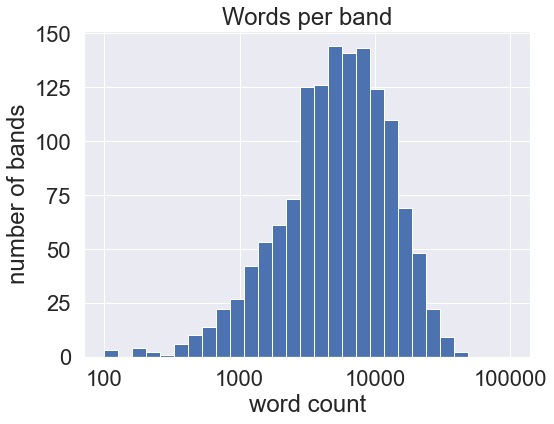

In [174]:
band_lyrics = df_r.groupby('band_name').song_darklyrics.sum()
band_word_counts = band_lyrics.str.split().apply(len)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
band_word_counts.hist(bins=np.logspace(2, 5, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of bands")
ax.set_title("Words per band")
plt.show()

In [248]:
df_r_bands = pd.concat((
    df_r_songs.groupby('band_name').first()['band_genre'],
    df_r_songs.groupby('band_name')[['song_word_count', 'song_seconds']].sum()
), axis=1).reset_index()
df_r_bands.columns = ['band_name', 'band_genre', 'band_word_count', 'band_seconds']
df_r_bands['band_words_per_second'] = df_r_bands.band_word_count / df_r_bands.band_seconds
df_r_bands.loc[df_r_bands['band_words_per_second'] == np.inf, 'band_words_per_second'] = 0

### Bands with highest word counts

In [249]:
df_r_bands.sort_values('band_word_count')[:-10:-1]

,band_name,band_genre,band_word_count,band_seconds,band_words_per_second
288,Cradle of Filth,"Death Metal (early), Symphonic Black Metal (mi...",44201,44097,1.002358
1058,Saxon,"NWOBHM, Heavy Metal",38925,53755,0.724119
661,Iron Maiden,"Heavy Metal, NWOBHM",36922,52673,0.700966
187,Blind Guardian,"Speed Metal (early), Power Metal (later)",36850,38090,0.967446
991,Rage,Heavy/Speed/Power Metal,36635,56064,0.653450
589,Helloween,Power/Speed Metal,35186,49300,0.713712
933,Overkill,Thrash Metal; Thrash/Groove Metal,34269,47540,0.720846
1160,Tankard,Thrash Metal,34099,38702,0.881066
675,Judas Priest,Heavy Metal,32222,51177,0.629619


### Bands with highest word density

In [250]:
df_r_bands.sort_values('band_words_per_second')[:-10:-1]

,band_name,band_genre,band_word_count,band_seconds,band_words_per_second
193,Blood Freak,Death Metal/Grindcore,6731,4447,1.513605
844,Municipal Waste,Thrash Metal/Crossover,11203,7479,1.497928
93,Archspire,Technical Death Metal,7618,5189,1.468106
28,Acrania,Brutal Deathcore,2449,1674,1.462963
137,Bal-Sagoth,Symphonic/Epic Black Metal,23032,16021,1.437613
211,Brujeria,Death Metal/Grindcore,9974,7045,1.415756
1175,The Berzerker,Industrial Death Metal/Grindcore,11127,8290,1.342220
79,Animosity,Death Metal/Metalcore/Grindcore,6089,4681,1.300790
475,Exhumed,Death Metal/Grindcore,16675,13765,1.211406


### Word counts by genre

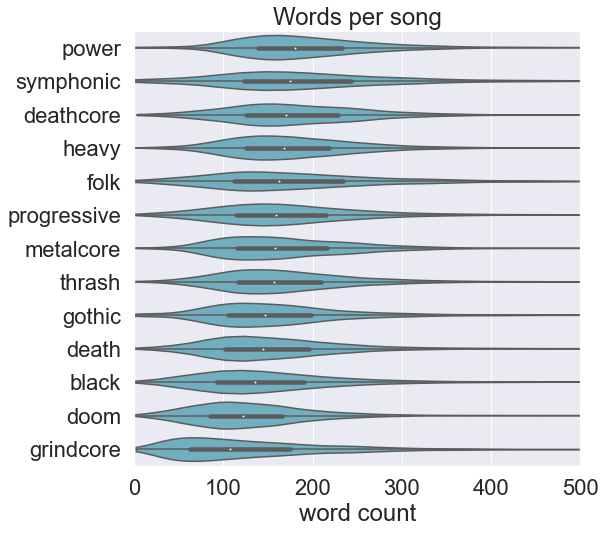

In [293]:
df_genre_songs = df_r[['band_name', 'album_name', 'song_name'] + [f"genre_{genre}" for genre in top_genres_1pct]].copy()
df_genre_songs['song_word_count'] = song_word_counts
df_genre_songs['song_seconds'] = song_seconds

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1]
    violindata.append((genre, df_genre['song_word_count']))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h', color='c')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_xlim(0, 500)
ax.set_title("Words per song")
ax.set_xlabel("word count")
plt.show()

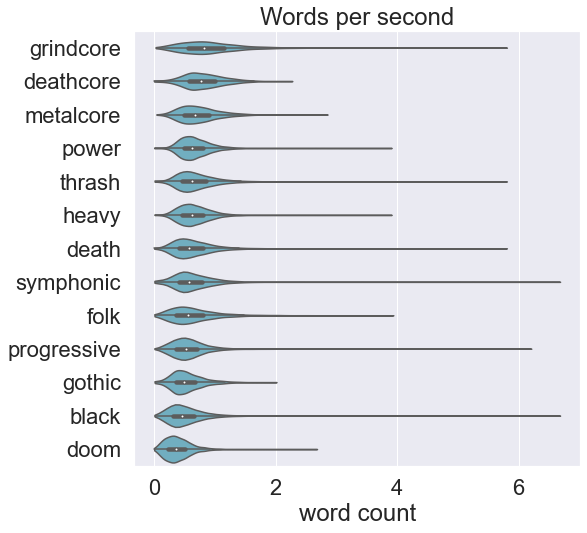

In [294]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1].copy()
    df_genre['song_words_per_second'] = df_genre['song_word_count'] / df_genre['song_seconds']
    df_genre.loc[df_genre['song_words_per_second'] == np.inf, 'song_words_per_second'] = 0
    violindata.append((genre, df_genre['song_words_per_second']))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h', color='c')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_title("Words per second")
ax.set_xlabel("word count")
plt.show()

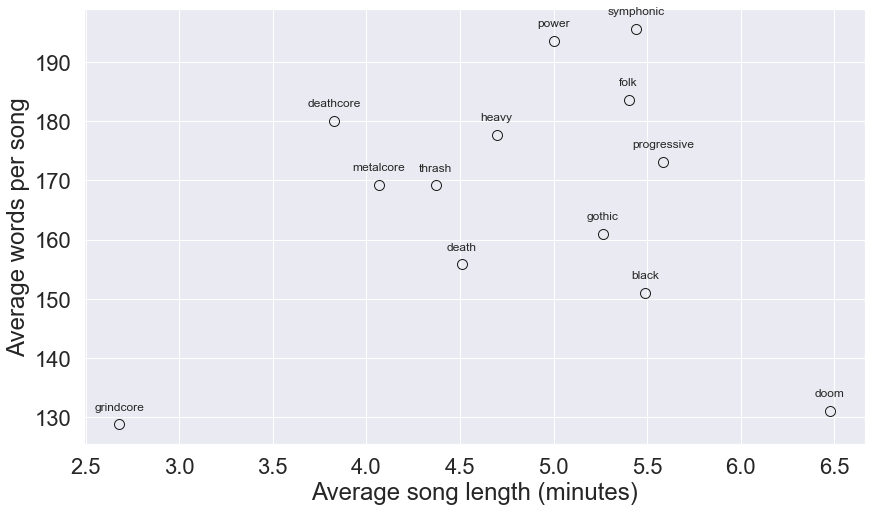

In [285]:
plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for genre in top_genres_10pct:
    df_genre = df_genre_songs[df_genre_songs['genre_' + genre] == 1].copy()
    x = df_genre['song_seconds'].mean() / 60.0
    y = df_genre['song_word_count'].mean()
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'o', color='none', markeredgecolor='k', markeredgewidth=1, markersize=10, label=genre)
ymin, ymax = plt.gca().get_ylim()
yoffset = 0.04 * (ymax - ymin)
for x, y, genre in zip(xlist, ylist, top_genres):
    plt.text(x, y + yoffset, genre, ha='center', va='center', fontsize=12)
plt.xlabel('Average song length (minutes)')
plt.ylabel('Average words per song')
plt.show()

In [295]:
df_genre_10pct_songs = df_rr[['band_name', 'album_name', 'song_name'] + [f"genre_{genre}" for genre in top_genres_10pct]].copy()
df_genre_10pct_songs['song_word_count'] = df_rr.song_darklyrics.str.split().apply(len)
df_genre_10pct_songs['song_seconds'] = to_seconds(df_rr)

C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


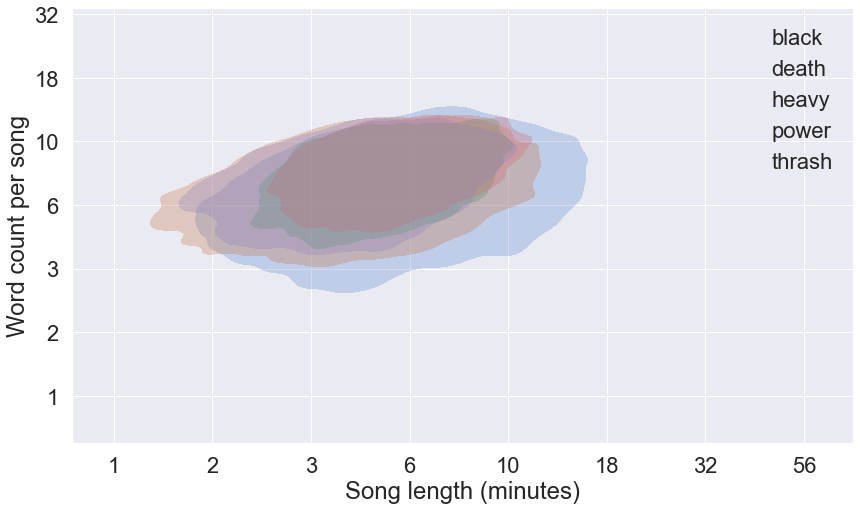

In [337]:
plt.figure(figsize=(14, 8))
ax = plt.gca()
for genre in top_genres_10pct:
    df_genre = df_genre_10pct_songs[df_genre_10pct_songs['genre_' + genre] == 1].copy()
    x = np.log10(df_genre['song_seconds'] / 60.0)
    y = np.log10(df_genre['song_word_count'])
    pos = (x > 0) & (y > 0)
    sns.kdeplot(x=x[pos], y=y[pos], levels=[0.05, 1], ax=ax, fill=True, alpha=0.3, label=genre)
ax.set_xticklabels([f"{10**tick:.0f}" for tick in ax.get_xticks()])
ax.set_yticklabels([f"{10**tick:.0f}" for tick in ax.get_xticks()])
plt.xlabel('Song length (minutes)')
plt.ylabel('Word count per song')
plt.legend()
plt.show()